In this code I developed a deep learning model based on glove for identifying authenticity of disaster tweets.


In [ ]:
from google.colab import drive
drive.mount(r'/content/drive/')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
import keras
import os
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPool1D, RNN, Embedding, Flatten, SimpleRNN, LSTM, Bidirectional, SpatialDropout1D
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras import preprocessing
from keras.optimizers import Adam
from keras.initializers import Constant
from sklearn.model_selection import train_test_split

import re
import string
from collections import  Counter
from sklearn.feature_extraction.text import CountVectorizer

import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from collections import defaultdict
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

nltk.download('punkt')

!pip install pyspellchecker
from spellchecker import SpellChecker

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
     |████████████████████████████████| 1.9MB 4.6MB/s 


In [3]:
#Importing train data and test data
data = pd.read_csv(r'/content/drive/My Drive/NLP Disaster/train.csv')
data_test = pd.read_csv(r'/content/drive/My Drive/NLP Disaster/test.csv')
print(data.info())
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB
None


The number of data with nan location:  2533
The number of not real disaster with nan location:  1075
The number of nique locations:  (3342,)
The number of not real disaster:  3271
The number of unique keywords : (222,)
Number of words in each case 0       13
1        7
2       22
3        8
4       16
        ..
7608    11
7609    20
7610     8
7611    19
7612    13
Name: text, Length: 7613, dtype: int64
Number of letters in each case 0        69
1        38
2       133
3        65
4        88
       ... 
7608     83
7609    125
7610     65
7611    137
7612     94
Name: text, Length: 7613, dtype: int64
The number of Disaster and Not Disaster Cases:  target  target
0       0         4342
1       1         3271
Name: target, dtype: int64


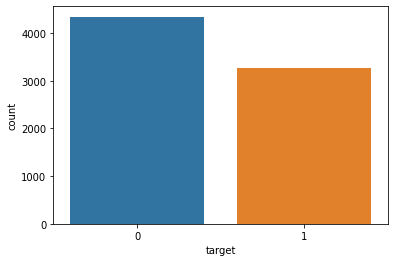

In [4]:
#General Data Inspection
print("The number of data with nan location: ", sum(pd.isnull(data['location'])))
print("The number of not real disaster with nan location: ", data[data.location.isnull() & data.target==1]['target'].sum())
print("The number of nique locations: ", data.location.unique().shape)
print("The number of not real disaster: ", data[data.target==1]['target'].count())
print("The number of unique keywords :", data.keyword.unique().shape)

print("Number of words in each case", data['text'].apply(lambda x:len(x.split())))
print("Number of letters in each case", data['text'].str.len())

print("The number of Disaster and Not Disaster Cases: ", data.groupby(by=['target'])['target'].value_counts())
sns.countplot(x='target', data=data)

In [41]:
#Finding the most common words
from collections import Counter
results = Counter()
data['text'].str.lower().str.split().apply(results.update)
# print(results)
# print(results.most_common)

0       None
1       None
2       None
3       None
4       None
        ... 
7608    None
7609    None
7610    None
7611    None
7612    None
Name: text, Length: 7613, dtype: object

Text(0.5, 0.98, 'The number of character in texts')

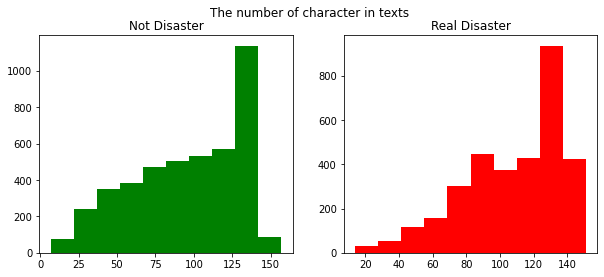

In [36]:
#Histogram of the number of Caracters in texts in 2 plots(Disaster & Not Disaster)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(10, 4))

text_len = data[data['target']==0]['text'].str.len()
ax1.hist(text_len, color='green')
ax1.set_title('Not Disaster')
text_len = data[data['target']==1]['text'].str.len()
ax2.hist(text_len, color='red')
ax2.set_title('Real Disaster')
fig.suptitle('The number of character in texts')

Text(0.5, 0.98, 'The number of words in texts')

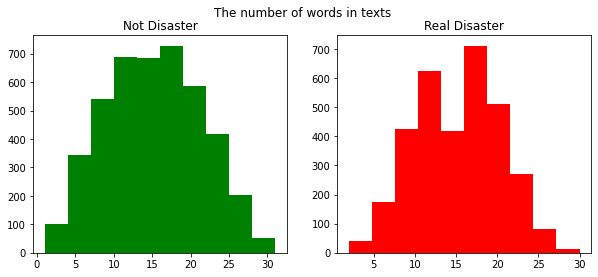

In [35]:
#Histogram of the number of Caracters in texts in 2 plots(Disaster & Not Disaster)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

text_len = data[data['target']==0]['text'].str.split().map(lambda x:len(x))
ax1.hist(text_len, color='green')
ax1.set_title('Not Disaster')

text_len = data[data['target']==1]['text'].str.split().map(lambda x:len(x))
ax2.hist(text_len, color='red')
ax2.set_title('Real Disaster')


fig.suptitle('The number of words in texts')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Real Disaster')

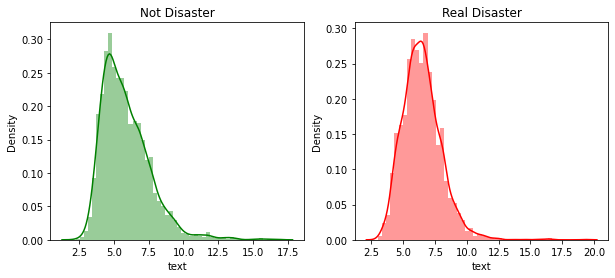

In [34]:
#Histogram of the mean of words' length in texts in 2 plots(Disaster & Not Disaster)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(10,4))

word_len = data[data['target']==0]['text'].str.split().map(lambda x:[len(i) for i in x])
sns.distplot(word_len.map(lambda x:np.mean(x)), color='green', ax=ax1)
ax1.set_title('Not Disaster')

word_len = data[data['target']==1]['text'].str.split().map(lambda x:[len(i) for i in x])
sns.distplot(word_len.map(lambda x:np.mean(x)), color='red', ax=ax2)
ax2.set_title('Real Disaster')

Text(0.5, 1.0, 'Not Disaster')

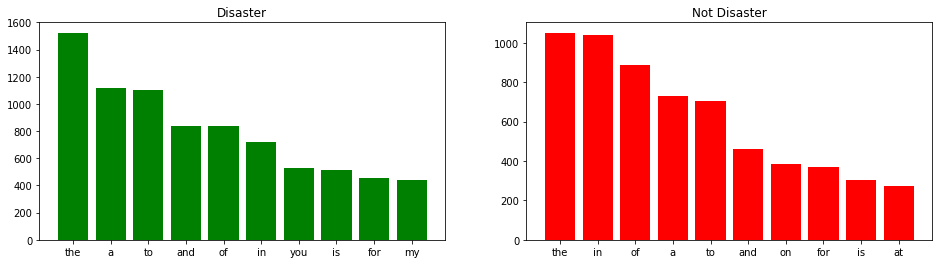

In [40]:
#The frequency of most common wors that are in stop words
def create_words(target):
    words=[]   
    for x in data[data['target']==target]['text'].str.split():
        for i in x:
            words.append(i)
    return words
#Not Disaster
words = create_words(0)
dic=defaultdict(int)
for word in words:
  if word in stop:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x:x[1] ,reverse=True)[:10]
x, y = zip(*top)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,4))
ax1.bar(x,y, color='green')
ax1.set_title("Disaster")

#Disaster
words = create_words(1)
dic=defaultdict(int)
for word in words:
  if word in stop:
    dic[word]+=1

top = sorted(dic.items(), key=lambda x:x[1] ,reverse=True)[:10]
x, y = zip(*top)

ax2.bar(x,y, color='red')
ax2.set_title("Not Disaster")

In [10]:
special = string.punctuation

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


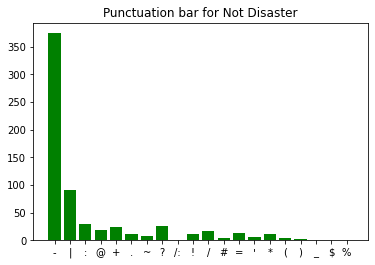

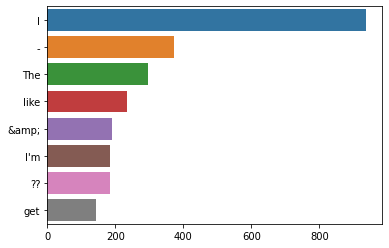

In [11]:
#Punctuation bar for Not Disaster
words = createwords(0)
dic=defaultdict(int)
for i in words:
  if i in special:
    dic[i]+=1
x,y =zip(*dic.items())
plt.bar(x, y, color='green')
plt.title('Punctuation bar for Not Disaster')

c = Counter(words)
most = c.most_common()
x=[]
y=[]
for word, count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)
plt.figure()
sns.barplot(y,x)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


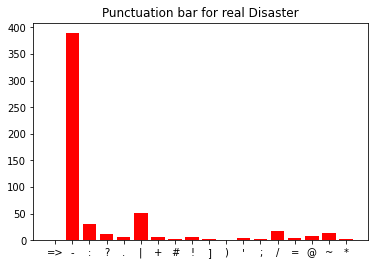

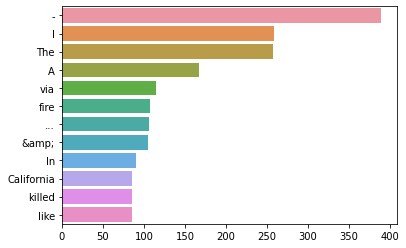

In [12]:
#Punctuation bar for Disaster
corpus = create_corpus(1)
dic=defaultdict(int)
for i in corpus:
  if i in special:
    dic[i]+=1
x,y =zip(*dic.items())
plt.bar(x, y, color='red')
plt.title('Punctuation bar for real Disaster')

c = Counter(corpus)
most = c.most_common()
x=[]
y=[]
for word, count in most[:40]:
  if word not in stop:
    x.append(word)
    y.append(count)
plt.figure()
sns.barplot(y,x)

In [13]:
def get_top_tweet_bigrams(corpus, n=None):
  vectorizer = CountVectorizer(ngram_range=(2, 2))
  bag_of_words = vectorizer.fit_transform(corpus)
  sum_words = bag_of_words.sum(axis=0)
  words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
  words_freq = sorted(words_freq, key= lambda x:x[1], reverse=True)
  return words_freq[:n]

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


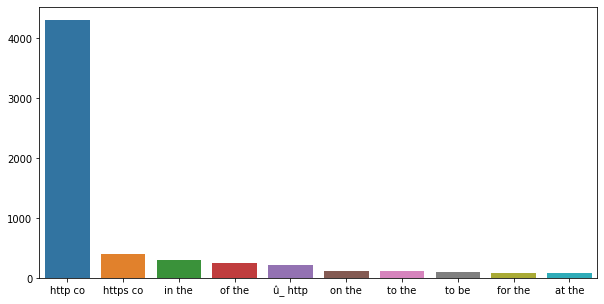

In [14]:
top_tweet_bigrams=get_top_tweet_bigrams(data['text'])[:10]
x,y=map(list,zip(*top_tweet_bigrams))
plt.figure(figsize=(10,5))
sns.barplot(x,y)

In [15]:
df = pd.concat([data, data_test])
df.shape

(10876, 5)

In [16]:
# Removing url, html, emoji and punctuation
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)
df['text'] = df['text'].apply(lambda x:remove_URL(x))
df['text'] = df['text'].apply(lambda x:remove_html(x))
df['text'] = df['text'].apply(lambda x:remove_emoji(x))
df['text'] = df['text'].apply(lambda x:remove_punct(x))

In [17]:
#Correcting Spell
from spellchecker import SpellChecker

spell = SpellChecker()
def correct_spell(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
df['text']=df['text'].apply(lambda x : correct_spell(x))

In [18]:
def create_corpus(df):
    corpus=[]
    for tweet in tqdm(df['text']):
        words=[word.lower() for word in word_tokenize(tweet) if((word.isalpha()==1) & (word not in stop))]
        corpus.append(words)
    return corpus

corpus=create_corpus(df)

100%|██████████| 10876/10876 [00:01<00:00, 7544.12it/s]


In [19]:
embedding_dict={}
with open('/content/drive/My Drive/NLP Disaster/glove.6B.100d.txt','r') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [21]:
#Number of unique words
MAX_LEN=50
tokenizer_obj=Tokenizer()
tokenizer_obj.fit_on_texts(corpus)
sequences=tokenizer_obj.texts_to_sequences(corpus)
tweet_pad=pad_sequences(sequences,maxlen=MAX_LEN,truncating='post',padding='post')
word_index=tokenizer_obj.word_index
print('Number of unique words:',len(word_index))

num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 19589/19589 [00:00<00:00, 555472.92it/s]


In [22]:
#MODEL
model = Sequential()
embedding = Embedding(num_words, 100, embeddings_initializer=Constant(embedding_matrix), input_length=MAX_LEN, trainable=False)
model.add(embedding)
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-5), metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 100)           1959000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 100)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 64)                42240     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 2,001,305
Trainable params: 42,305
Non-trainable params: 1,959,000
_________________________________________________________________


In [31]:
train = tweet_pad[:data.shape[0]]
test = tweet_pad[data.shape[0]:]
X_train,X_test,y_train,y_test=train_test_split(train,data['target'].values,test_size=0.15)
print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)
history=model.fit(X_train,y_train,batch_size=4,epochs=100,validation_data=(X_test,y_test), verbose=1)

Shape of train (6471, 50)
Shape of Validation  (1142, 50)
Epoch 1/100
1618/1618 [==============================] - 77s 48ms/step - loss: 0.4772 - acc: 0.7870 - val_loss: 0.4375 - val_acc: 0.8152
Epoch 2/100
1618/1618 [==============================] - 76s 47ms/step - loss: 0.4714 - acc: 0.7900 - val_loss: 0.4370 - val_acc: 0.8109
Epoch 3/100
1618/1618 [==============================] - 76s 47ms/step - loss: 0.4725 - acc: 0.7887 - val_loss: 0.4373 - val_acc: 0.8117
Epoch 4/100
1618/1618 [==============================] - 76s 47ms/step - loss: 0.4686 - acc: 0.7937 - val_loss: 0.4369 - val_acc: 0.8109
Epoch 5/100
1618/1618 [==============================] - 77s 48ms/step - loss: 0.4701 - acc: 0.7889 - val_loss: 0.4360 - val_acc: 0.8135
Epoch 6/100
1618/1618 [==============================] - 76s 47ms/step - loss: 0.4670 - acc: 0.7912 - val_loss: 0.4360 - val_acc: 0.8144
Epoch 7/100
1618/1618 [==============================] - 77s 47ms/step - loss: 0.4629 - acc: 0.7963 - val_loss: 0.4345 -

In [27]:
y_pre=model.predict(test)
y_pre=np.round(y_pre).astype(int).reshape(3263)